In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import os
if not os.path.exists('/content/L_7classes'):
    os.makedirs('/content/L_7classes')

In [4]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/region/L/aug_all_L.zip -d /content/L_7classes

In [5]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
!nvidia-smi

Thu May 30 00:15:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P8              13W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [8]:
batch_size = 64
img_size = 224
model_type = 'regionL-all'

data_dir = '/content/L_7classes'

In [ ]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize
)

dataset = datasets.ImageFolder(data_dir, ToTensor())

In [ ]:
def get_norm_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for inputs, _ in dataset:
        for i in range(3):
            mean[i] += inputs[i,:,:].mean()
            std[i] += inputs[i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))

    return mean, std

In [ ]:
# mean_ = (0.5589, 0.5298, 0.5114)
# std_ = (0.2119, 0.2031, 0.2015)
mean_, std_ = get_norm_std(dataset)
print(mean_, std_)

tensor([0.5451, 0.5180, 0.5032]) tensor([0.1671, 0.1758, 0.1764])


In [ ]:
mean_ = ()
std_ = ()

In [10]:
transforms = Compose(
        [
            ToTensor(),
            Normalize(mean_, std_)
        ]
    )

In [11]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [12]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [36]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴',
 'A7_무증상']

In [37]:
print(len(train_dataset), len(valid_dataset))

89980 22496


In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

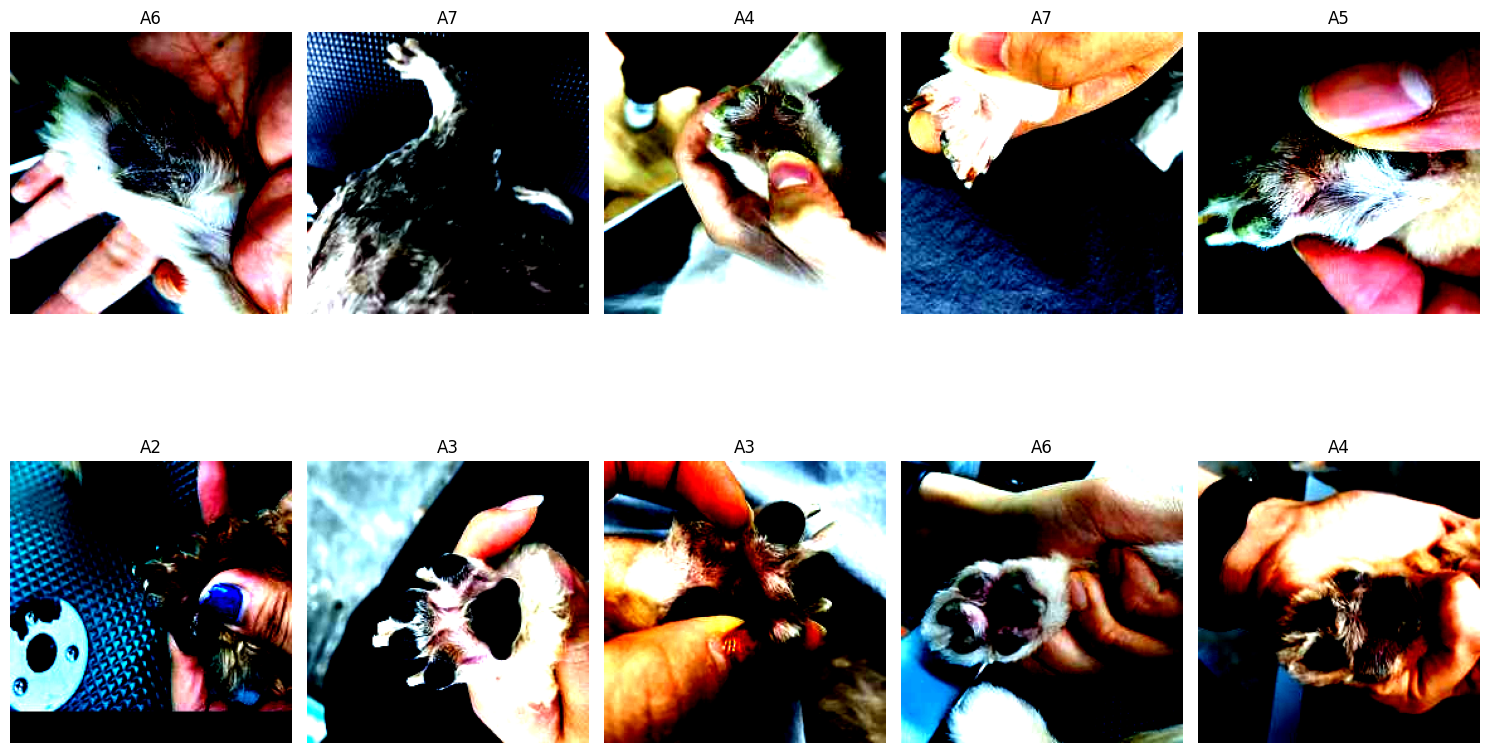

In [39]:
valid_10 = [valid_dataset[i] for i in random.sample(list(range(0, len(valid_dataset))), 10)]

fig, ax = plt.subplots(2, 5, figsize=(15, 10), tight_layout=True)

for i in range(2):
    for j in range(5):
        img = valid_10[(i*5)+j][0]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[valid_10[(i*5)+j][1]][:2])
        ax[i][j].axis('off')

plt.show()

# Model Training

In [40]:
# inception_v4 1536
# inception_resnet_v2 1536
# resnet50 2048
# resnetv2_50 2048
# efficientnet_b0 1280
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# vit_base_resnet26d_224 768
# vit_base_resnet50d_224 768
# vit_small_resnet26d_224 768
# vit_small_resnet50d_s16_224 768

In [41]:
model_name = 'efficientnet_b0'
hidden_size = 640
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=hidden_size)

In [42]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [43]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [44]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [45]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [46]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [47]:
classifier = Classifier(model, hidden_size, num_classes=num_classes).to(device)
# classifier = model.to(device)

In [48]:
opt_name = 'AdamW'
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                         factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [49]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [50]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [51]:
def load_dict(model, optimizer, lr_scheduler, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)

    return epoch, labels, model, optimizer, lr_scheduler

In [52]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [54]:
file_path = model_path

pretrained = False

In [55]:
num_epochs = 10

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}_10epoch.pt')
    pkl_file = os.path.join(file_path, f'{model_name}_10epoch.pickle')

    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [56]:
print(epoch_start, best_val_acc, best_val_loss)

0 0.0 100.0


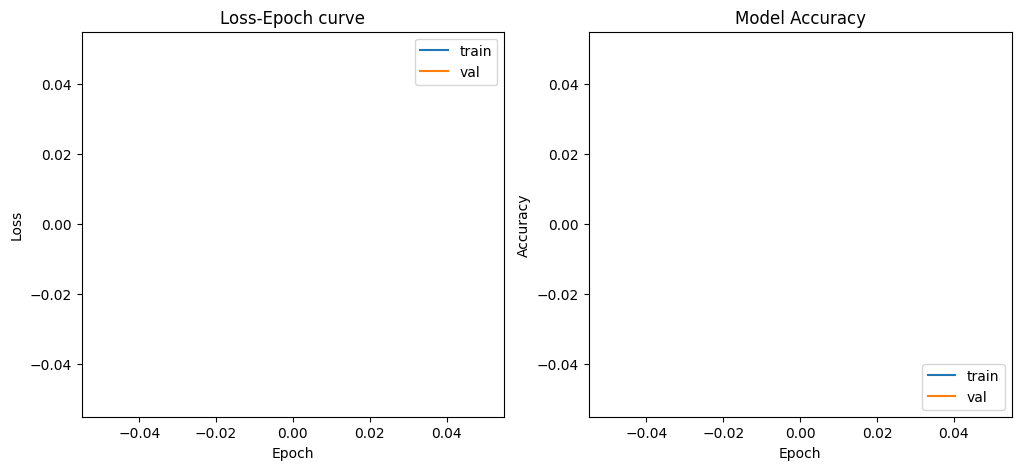

In [57]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [ ]:
epoch_start = e

epoch 5 train acc 0.8306032183499289 validation acc 0.7813387784090909


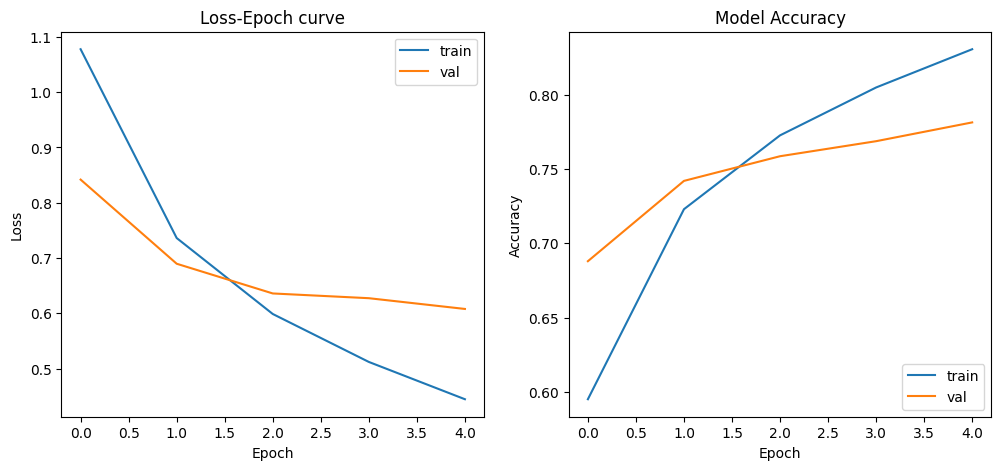

  0%|          | 0/1406 [00:00<?, ?it/s]

epoch 6 train acc 0.8506971609767662 loss 0.391060132220663 lr 0.001


  0%|          | 0/352 [00:00<?, ?it/s]

epoch 6 valid acc 0.7835138494318182 loss 0.6079004443335262


  0%|          | 0/1406 [00:00<?, ?it/s]

epoch 7 train acc 0.8688574265054527 loss 0.3444559940986155 lr 0.001


  0%|          | 0/352 [00:00<?, ?it/s]

epoch 7 valid acc 0.7840909090909091 loss 0.61591547194191


  0%|          | 0/1406 [00:00<?, ?it/s]

epoch 8 train acc 0.8837711889521099 loss 0.30334548384565885 lr 0.001


  0%|          | 0/352 [00:00<?, ?it/s]

epoch 8 valid acc 0.7770330255681818 loss 0.6400899518789216


  0%|          | 0/1406 [00:00<?, ?it/s]

epoch 9 train acc 0.9358189604077762 loss 0.16732040653601396 lr 0.0005


  0%|          | 0/352 [00:00<?, ?it/s]

epoch 9 valid acc 0.8029119318181818 loss 0.7170589617876844


  0%|          | 0/1406 [00:00<?, ?it/s]

epoch 10 train acc 0.9532909554291134 loss 0.12251238700911234 lr 0.0005


  0%|          | 0/352 [00:00<?, ?it/s]

epoch 10 valid acc 0.7976296164772727 loss 0.7868743057532067


In [58]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {} lr {}".format(e, tot_train_acc, mean_train_loss, lr))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)

    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, f"{model_name}_{opt_name}")

In [85]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                model_path, f"{model_name}_{opt_name}_{e}epoch")

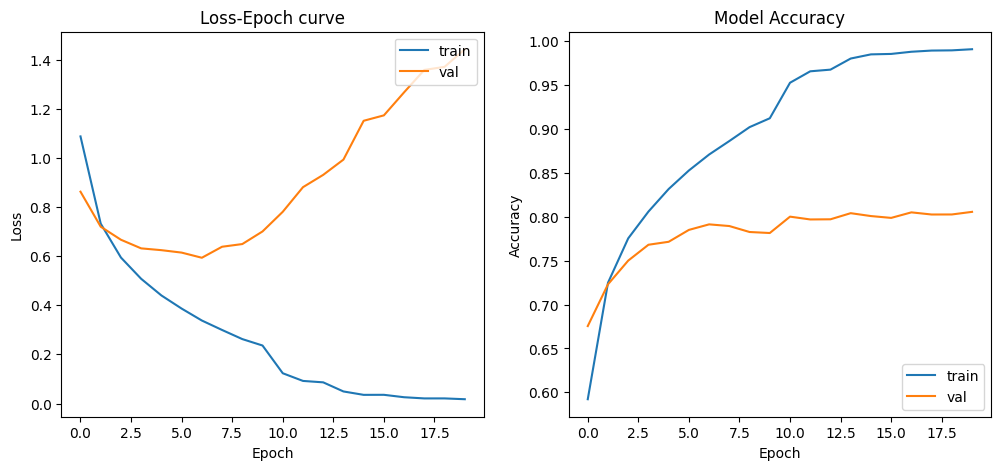

In [35]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

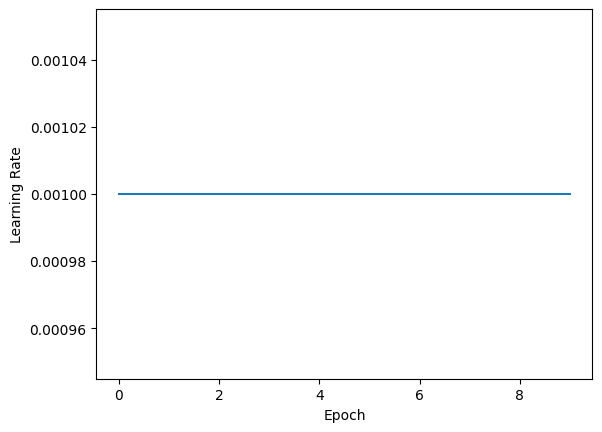

In [87]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# Inference

In [ ]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img)
    img = Normalize(mean_, std_)(img).unsqueeze(0)

    outputs = classifier(img.to(device))
    result = outputs.softmax(1) # logits.
    result_dict = {}

    for i, value in enumerate(result[0].tolist()):
        result_dict[labels[i]] = value

    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return result

In [ ]:
file_root = '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized'
test_files = []
for folder in os.listdir(file_root):
    files = random.sample(os.listdir(os.path.join(file_root, folder)), 1)
    test_files.extend([os.path.join(file_root, folder, file) for file in files])
print(test_files)

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A1_구진_플라크/IMG_D_A1_037705.jpg /content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A7_무증상/IMG_D_A7_395761.jpg /content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A2_비듬_각질_상피성잔고리/IMG_D_A2_602536.jpg /content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A3_태선화_과다색소침착/IMG_D_A3_178326.jpg /content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A4_농포_여드름/IMG_D_A4_446833.jpg /content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A5_미란_궤양/IMG_D_A5_492675.jpg /content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A6_결절_종괴/IMG_D_A6_497949.jpg


In [ ]:
for file in test_files:
    result = inference(file)
    print(file)
    print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')
    print()

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A1_구진_플라크/IMG_D_A1_037705.jpg
A3_태선화_과다색소침착일 확률이 92%, A7_무증상일 확률이 6% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A7_무증상/IMG_D_A7_395761.jpg
A4_농포_여드름일 확률이 60%, A5_미란_궤양일 확률이 17% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A2_비듬_각질_상피성잔고리/IMG_D_A2_602536.jpg
A5_미란_궤양일 확률이 97%, A2_비듬_각질_상피성잔고리일 확률이 2% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A3_태선화_과다색소침착/IMG_D_A3_178326.jpg
A2_비듬_각질_상피성잔고리일 확률이 68%, A3_태선화_과다색소침착일 확률이 31% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A4_농포_여드름/IMG_D_A4_446833.jpg
A2_비듬_각질_상피성잔고리일 확률이 99%, A3_태선화_과다색소침착일 확률이 0% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A5_미란_궤양/IMG_D_A5_492675.jpg
A5_미란_궤양일 확률이 99%, A7_무증상일 확률이 0% 입니다.

/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized/A6_결절_ᄌ

In [ ]:
# file_path = '/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg'
# result = inference(file_path)
# print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')

In [ ]:
# img = Image.open('/kaggle/input/skin-cat/test_cat_resized/A2_비듬_각질_상피성잔고리/IMG_C_A2_201688.jpg')
# encoding = feature_extractor(images=img, return_tensors='pt')

In [ ]:
# !pip install onnxruntime

In [ ]:
# import onnxruntime
# import time

# ort_session = onnxruntime.InferenceSession(filepath)
# input_name = ort_session.get_inputs()[0].name
# ort_inputs = {input_name: encoding['pixel_values'].numpy()}

# s = time.time()
# ort_outs = ort_session.run(None, ort_inputs)
# e = time.time()

# print(f'inference takes {e-s} sec')

In [ ]:
# from scipy.special import softmax

In [ ]:
# softmax(ort_outs)

In [ ]:
# encoding['pixel_values'].size()

In [ ]:
# ort_inputs

In [ ]:
# dataset.class_to_idx

In [ ]:
# import pickle

# with open('/kaggle/working/classes.pkl', 'wb') as f:
#     pickle.dump(id2label, f)